# Проект gamedev analysis
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:


### Задачи
* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

<hr>

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared:
* shared/problem1-reg_data.csv – данные о времени регистрации
* shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

### Этапы работы:
1. Загрузка и предобработка данных
2. Написание функции для показателя retention

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [ ]:
# считываем данные из csv из папки shared:
df_reg = pd.read_csv('../shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('../shared/problem1-auth_data.csv', sep=';')

### 1. Посмотрим, какой объем данных содержится в каждом датафрейме, какой формат данных, есть ли нулевые значения.

In [4]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

По полученным данным видим, что датафрейм df_reg имеет данные о времени регистрации, состоит из двух столбцов типа int64, содержит 1 000 000 записей пропущенных значений в датафрейме нет.

In [7]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [8]:
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

По полученным данным видим, что датафрейм df_auth имеет данные о времени захода в игру, состоит из двух столбцов типа int64, содержит 9 601 013 записей, пропущенных значений в датафрейме нет

In [ ]:
# соединим два датафрейма в один, чтобы иметь всю информацию о пользователях в одном месте
df_all = df_reg.merge(df_auth, on='uid', how='left')

In [11]:
df_all.head()

,reg_ts,uid,auth_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932683089,2,932921206
3,932683089,2,933393015
4,932683089,2,933875379


In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   reg_ts   int64
 1   uid      int64
 2   auth_ts  int64
dtypes: int64(3)
memory usage: 293.0 MB


In [13]:
df_all.isna().sum()

reg_ts     0
uid        0
auth_ts    0
dtype: int64

По полученным данным видим, что количество записей 9 601 013, как и в датафрейме df_auth, пропущенных значений нет

In [ ]:
# отобразим даты регистрации и времени захода в игру в привычном формате даты
df_all['reg'] = pd.to_datetime(pd.to_datetime(df_all.reg_ts, unit='s').dt.date)
df_all['auth'] = pd.to_datetime(pd.to_datetime(df_all.auth_ts, unit='s').dt.date)

In [ ]:
# старые столбцы reg_ts и auth_ts с обозначением даты регистрации и даты захода типа int64 больше не нужны, удалим их
df_all = df_all.drop(['reg_ts', 'auth_ts'], axis=1)

Теперь мы получили датафрейм с uid пользователя, его датой регистрации и его последющими датами захода в игру

In [16]:
df_all.head()

,uid,reg,auth
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   uid     int64         
 1   reg     datetime64[ns]
 2   auth    datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 293.0 MB


In [18]:
df_all[['reg', 'auth']].describe(datetime_is_numeric=True)

,reg,auth
count,9601013,9601013
mean,2017-10-08 00:24:21.283808,2019-01-29 04:12:09.041569792
min,1998-11-18 00:00:00,1998-11-18 00:00:00
25%,2016-08-26 00:00:00,2018-06-07 00:00:00
50%,2018-04-19 00:00:00,2019-07-31 00:00:00
75%,2019-06-19 00:00:00,2020-04-02 00:00:00
max,2020-09-23 00:00:00,2020-09-23 00:00:00


In [19]:
df_all.duplicated().sum()

0

### 2. Написание функции расчета retention.

Стоит замметить, что на различных срезах даты регистрации может изменяться форма презентации данных, так как отсутствуют заходы в игру из-за малой активности пользователей.

In [23]:
def retention2(df, beginning_date, end_date, period=7):
    # добавляем столбец с количеством дней между регистрацией и заходом в игру, сохраняем в новый датафрейм:
    new_df = df.assign(days_gone=(df.auth - df.reg).dt.days)
    # так как тип даты регистрации datetime64,
    # то переведем даты в формат г-м-д для дальнейшего корректного отображения в тепловой карте:
    new_df['reg'] = new_df.reg.dt.strftime('%Y-%m-%d')
    # обрежем датафрейм только по входящему параметру количества дней с даты регистрации:
    cut_period_df = new_df.query('days_gone <= @period')
    # делаем из датафрема таблицу, считаем % retention и удаляем 0 день,
    # так как дата первого захода всегда равна дате регистрации и данные в 0 дней всегда будлут равны 1
    retention_pivot = cut_period_df \
        .pivot_table(index='reg', columns='days_gone', values='uid', aggfunc='sum', fill_value=0) \
        .apply(lambda x: x / x[0], axis=1).round(3).drop(0, axis=1)
    # только теперь ограничиваем полученную таблицу retention по датам регистрации
    cut_retention_pivot = retention_pivot.query('reg >= @beginning_date and reg <= @end_date')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(cut_retention_pivot, annot=True, fmt=".1%", cmap="YlGn", linewidth=.5)
    plt.title("Retention", fontsize=14)
    plt.ylabel("Reg date", fontsize=10)
    plt.xlabel("Period", fontsize=10)
    plt.tight_layout()
    plt.show()

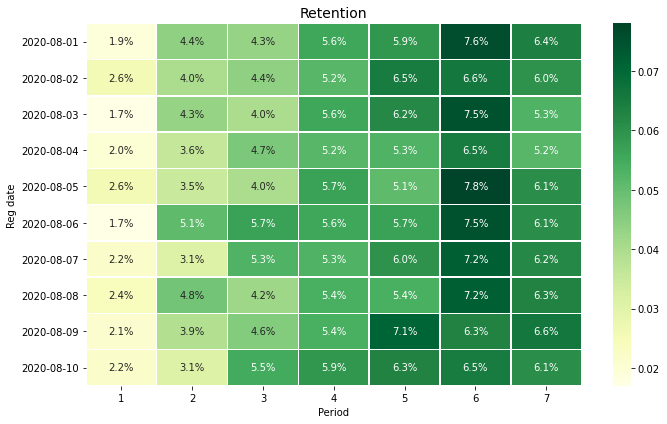

In [24]:
retention2(df_all, '2020-08-01', '2020-08-10')

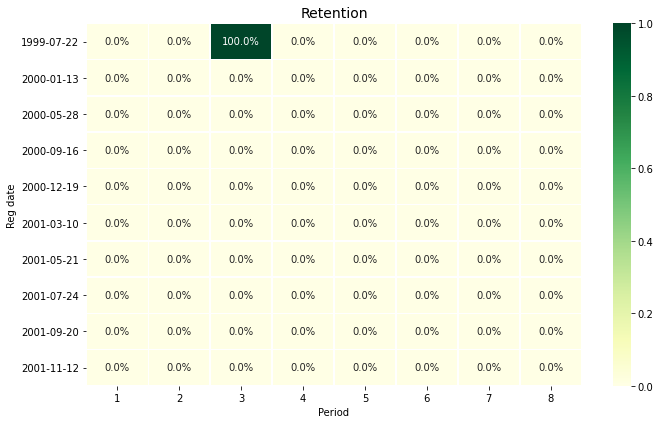

In [25]:
retention2(df_all, '1999-06-02', '2001-12-01', 8)

<hr>

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

* Какой набор предложений можно считать лучшим? 
* Какие метрики стоит проанализировать для принятия правильного решения и как?

### Этапы работы
1. загрузка и предобработка данных
2. Расчет метрик  
2.1 Проверка ARPU на статзначимость  
2.2 Проверка ARPPU на статзначимость  
2.3 Проверка CR на статзначимость  
3. Вывод

In [ ]:
# считываем данные
df_ab = pd.read_csv('../Проект_1_Задание_2.csv', sep=';')

### 1. Посмотрим, какой объем данных содержится в датафрейме, какой формат данных, есть ли нулевые значения.

In [27]:
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [28]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [29]:
df_ab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [30]:
df_ab.value_counts('user_id').head()

user_id
404770    1
134916    1
134918    1
134919    1
134920    1
dtype: int64

По полученным данным видим, что датафрейм df_ab имеет данные по двум группам пользователей, где user_id и revenue типа int64, testgroup типа object, который содержит 404 770 записей, пропущенных значенией в датафрейме нет

при этом user_id не повторяется

In [ ]:
# определим, какая из групп тестовая, а какая контрольная согласно вводным из условия
df_ab.value_counts('testgroup')

testgroup
b    202667
a    202103
dtype: int64

a - контрольная группа, b - тестовая группа

Теперь для удобства переименуем группы и раздеим на два датафрейма.

In [32]:
df_ab['testgroup'] = df_ab.testgroup.replace({'a': 'control', 'b': 'test'})
df_control = df_ab.query('testgroup == "control"')
df_test = df_ab.query('testgroup == "test"')

In [33]:
df_control.head()

,user_id,revenue,testgroup
1,2,0,control
2,3,0,control
9,10,0,control
10,11,0,control
11,12,0,control


In [34]:
df_test.head()

,user_id,revenue,testgroup
0,1,0,test
3,4,0,test
4,5,0,test
5,6,0,test
6,7,0,test


### 2. Расчет метрик.

В наших данных отсутствуют даты покупок и все пользователи уникальны, поэтому посчитать метрики, относящиеся к аудитории (RR, Mau, Dau) не представляется возможным.

В данных отсутствуют какие-либо расходы, поэтому посчитать метрики окупаемости и привлечения (ROI, ROMI, ROAS, CPAcq, CAC) тоже не представляется возможным.

Только по выручке и количестве пользователей возможно расчитать ARPU, ARPPU и CR.


In [ ]:
# рассчет метрики ARPU в тестовой и контрольной группе
arpu_control = df_control.revenue.sum() / df_control.user_id.count()
arpu_test = df_test.revenue.sum() / df_test.user_id.count()
print(f'ARPU control group: {round(arpu_control, 1)}')
print(f'ARPU test group: {round(arpu_test, 1)}')
print(f'differences %: {round((arpu_test / arpu_control - 1) * 100, 1)}%')

ARPU control group: 25.4
ARPU test group: 26.8
differences %: 5.3%


In [ ]:
# рассчет метрики ARPPU в тестовой и конгтрольной группе
arppu_control = df_control.revenue.sum() / df_control.query('revenue > 0').user_id.count()
arppu_test = df_test.revenue.sum() / df_test.query('revenue > 0').user_id.count()
print(f'ARPPU control group: {round(arppu_control, 1)}')
print(f'ARPPU test group: {round(arppu_test, 1)}')
print(f'differences %: {round((arppu_test / arppu_control - 1) * 100, 1)}%')

ARPPU control group: 2664.0
ARPPU test group: 3003.7
differences %: 12.7%


In [ ]:
# рассчет метрики CR в тестовой и контрольной группе
cr_control = df_control.query('revenue > 0').user_id.count() / df_control.user_id.count() * 100
cr_test = df_test.query('revenue > 0').user_id.count() / df_test.user_id.count() * 100
print(f'CR control group: {round(cr_control, 2)}%')
print(f'CR test group: {round(cr_test, 2)}%')
print(f'differences %: {round(cr_test - cr_control, 2)}%')

CR control group: 0.95%
CR test group: 0.89%
differences %: -0.06%


По полученным результатам расчета по метрикам:

* ARPU тестовой группы выше на 5,3%, чем в констрольной группе, как и указано в задании

* ARPPU тестовой группы выше на 12,7%, чем в контрольной группе

* CR тестовой группы ниже на 0,06% (абсолютная разница), чем контрольная группа

Чтобы в дальнейшем делать выводы стоит проверить отличия для каждой метрики на статзначимость.

### 2.1 Проверяем ARPU на статзначимость

Text(0.5, 1.0, 'test')

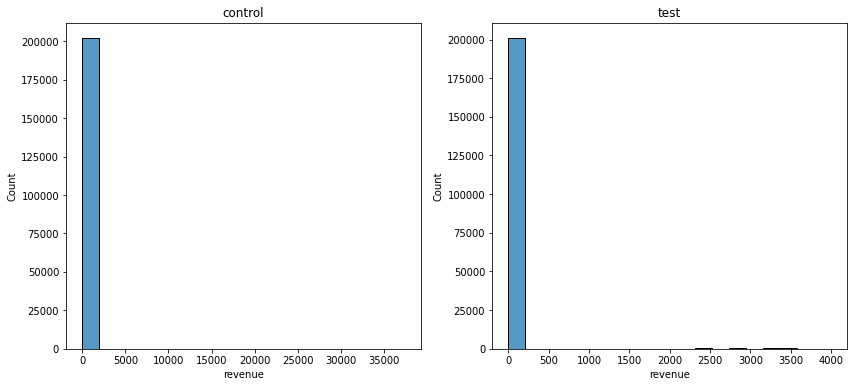

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_control, x='revenue')
plt.title('control')

plt.subplot(1, 2, 2)
sns.histplot(df_test, x='revenue')
plt.title('test')

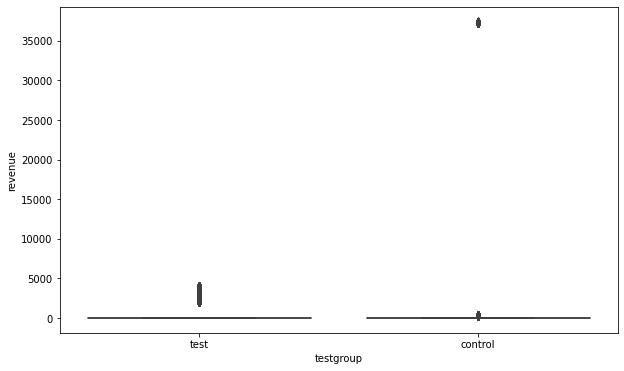

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ab, x='testgroup', y='revenue')

По гистограмме и боксплоту видно, что тестовая группа имеет меньший разброс, чем контрольная, причем в контрольной группе есть revenue более 35000 уе, когда в тестовой значения не более 4000 уе.

Теперь проверим дисперсию на однородность с помощью критерия Левена.

In [ ]:
# Проверим дисперсию на однородность с помощью критерия Левена
pg.homoscedasticity(data=df_ab, dv='revenue', group='testgroup', method='levene')

,W,pval,equal_var
levene,0.389629,0.532495,True


p-value > 0,05, поэтому гипотезу о том, что дисперсии однородны, отклонить не можем, значимых различий нет.


In [ ]:
# проверим на нормальность распределения контрольную группу
pg.normality(df_control.revenue, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


In [ ]:
# проверим на нормальность распределения тестовую группу
pg.normality(df_test.revenue, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


Распределение в обоих группах не нормально, но так как дисперсия однородна и выборка большая можем применить t-test Стьюдента.

In [ ]:
# t-test Стьюдента
pg.ttest(df_control.revenue, df_test.revenue, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.624203,404768,two-sided,0.532495,"[-5.54, 2.86]",0.001962,0.004,0.095694


p-value > 0,05, поэтому гипотезу об отсутствии различий метрики ARPU между тестовой и контрольной выборкой отклонить не можем, статзначимых различий нет

### 2.2 Проверим ARPPU на статзначимость

In [44]:
df_control_arppu = df_control.query('revenue > 0')
df_test_arppu = df_test.query('revenue > 0')

Text(0.5, 1.0, 'test')

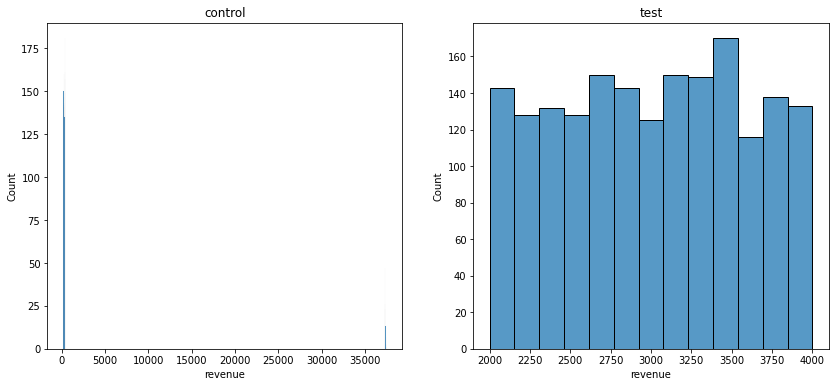

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_control_arppu, x='revenue')
plt.title('control')

plt.subplot(1, 2, 2)
sns.histplot(df_test_arppu, x='revenue')
plt.title('test')

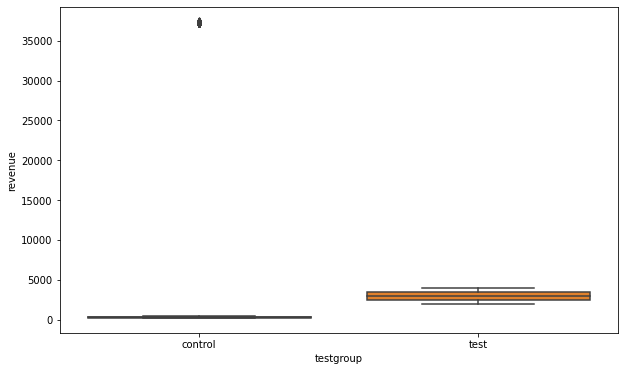

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ab.query('revenue > 0'), x='testgroup', y='revenue')

In [ ]:
# Проверим данные на однородность дисперсии
pg.homoscedasticity(data=df_ab.query('revenue > 0'), dv='revenue', group='testgroup', method='levene')

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


p-value < 0,05, поэтому гипотезу о том, что дисперсии однородны, принять не можем, статзначимые различия есть.


In [ ]:
# Проверим на нормальность распределения контрольной группы
pg.normality(df_control_arppu.revenue, method='normaltest')

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


In [ ]:
# Проверим на нормальность распределения тестовой группы
pg.normality(df_test_arppu.revenue, method='normaltest')

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


Распределение в обоих группах не нормально, дисперсия не однородна, поэтому t-test Стьюдента применить не можем, но так как выборка большая, можем применить t-test Уэлча.

In [ ]:
# t-test Уэлча
pg.ttest(df_control_arppu.revenue, df_test_arppu.revenue, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


p-value > 0,05, поэтому гипотезу об отсутствии различий метрики ARPPU между тестовой и контрольной выборкой отклонить не можем, статзначимых различий нет

### 2.3 Проверим CR на статзначимость

Создадим дополнительный столбец, в котором True - есть продажи, False - нет продаж

In [51]:
df_ab['group_revenue'] = df_ab.revenue.apply(lambda x: x > 0)

In [52]:
df_ab_pivot = df_ab.pivot_table(index='group_revenue', columns='testgroup', values='user_id', aggfunc='count')
df_ab_pivot

testgroup,control,test
group_revenue,,
False,200175,200862
True,1928,1805


Применим хи-квадрат.

In [53]:
pg.chi2_independence(df_ab, x='group_revenue', y='testgroup')

(testgroup            control           test
 group_revenue                              
 False          200239.100751  200797.899249
 True             1863.899249    1869.100751,
 testgroup       control      test
 group_revenue                    
 False          200175.5  200861.5
 True             1927.5    1805.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  4.374730  1.0  0.036476  0.003288  0.552384
 1        cressie-read  0.666667  4.374870  1.0  0.036473  0.003288  0.552397
 2      log-likelihood  0.000000  4.375431  1.0  0.036461  0.003288  0.552450
 3       freeman-tukey -0.500000  4.376097  1.0  0.036446  0.003288  0.552513
 4  mod-log-likelihood -1.000000  4.376973  1.0  0.036428  0.003288  0.552596
 5              neyman -2.000000  4.379356  1.0  0.036377  0.003289  0.552821)

p-value < 0,05, поэтому гипотезу об отсутствии различий метрики CR между тестовой и контрольной выборкой принять не можем, статзначимых различия есть

**Вывод:**

ARPU и ARPPU не имеют статзначимых различий, поэтому не делаем выводы на основе различий этих метрик.

CR двух групп имеет статзначимое различие, и поскольку в тестовой группе он ниже на 0,06% (абсолютная разница), то набор предложений из контрольной группы можно считать лучшим.

<hr> 

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Метрики первой части:**

* MAU месячная аудитория, WAU недельная аудитория, DAU дневная аудитория и средняя дневная аудитория - выбирать в зависимости от ограничения события по времени (например, если событие идет неделю, то для анализа события MAU не подходит)

* Retantion Rate - как на протяжении события игроки будут возвращаться в игру

* CR конверсия дополнительных уровней - какая доля игроков помимо основного сюжета игры будет проходить ряд уровней тематического события

* ARPU и ARPPU - при наличии возможности покупать внутреигровую валюту за реальные деньги, за которую можно получить преимущество перед другими игроками тематического события (например купить больше попыток пройти уровень)

* ASL средняя продолжительность сессии - насколько увеличивается время в игру во время проведения тематического события

**Метрики второй части** в дополнение вышеописанным, если усложнилась механика событий (при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад):

* Churn Rate - как на протяжении события игроки перестанут возвращаться в игру (отток игроков)

* NPS и CSAT - мнение игроков об усложненной механике

* Процент игроков, прошедших все уровни тематического события - метрика поможет регулировать уровень сложности и ценность финальных наград за полное прохождение

**Вывод:**

При первом варианте проведения события используются базовые метрики оценки результатов события. Во втором варианте проведения события добавляется составляющая, способная негативно влиять на метрики первого варината, поэтому появляется необходимость отслеживать дополнительные метрики, с помощью которых можно изменять уровень сложности и лояльность игроков к событию.